In [1]:
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate

##############
import os

from os import listdir
from os.path import isfile, join
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import InceptionV3

In [2]:
currentPath = os.getcwd()
print(currentPath)

C:\Users\CARLOS CORDERO\Desktop\ToG_pretrain


In [3]:
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


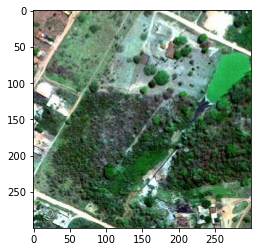

In [4]:
trainDB = currentPath + os.sep + "dataset" + os.sep + "train20"
valDB = currentPath + os.sep + "dataset"+ os.sep +"val20"
InceptionWeightsPretrained = currentPath + os.sep + "inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_name = "InceptionV3"
classList = os.listdir(trainDB)
classList.sort()

img = mpimg.imread(trainDB + os.sep + "airport" + os.sep + "airport_7_8_msrgb.jpg")
imgplot = plt.imshow(img)

In [5]:
lr = 0.00005
batch_size = 10
num_epochs = 200
num_steps_per_epoch = 4
img_rows, img_cols, img_channel = 299, 299, 3
num_categories = len(classList)

In [6]:
# First LR range analysis
# tensorboardLogsPath = "logs/lrfirtsstep/" + model_name
# LR fine tunning analysis
# tensorboardLogsPath = "logs/lrfine/" + model_name + "/lr-" + str(lr)
# model graph 
tensorboardLogsPath = "logs/modelgraph/" + model_name
tensorboardCallback = tensorflow.keras.callbacks.TensorBoard(tensorboardLogsPath)

In [7]:
# First LR range analysis
#def scheduler(epoch):
#    return (0.5 * (10**(-1*(epoch//20))))
#lrSchcallback = tensorflow.keras.callbacks.LearningRateScheduler(scheduler)

In [8]:
train_data_gen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=270,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval = 0.)
    
train_generator = train_data_gen.flow_from_directory(
    directory=trainDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data_gen = ImageDataGenerator(
    rescale=1. / 225,
)
val_generator = val_data_gen.flow_from_directory(
    directory=valDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 105 images belonging to 7 classes.
Found 34 images belonging to 7 classes.


In [9]:
print(train_generator.class_indices)
imgs, labels = next(train_generator)

{'airport': 0, 'airport_hangar': 1, 'airport_terminal': 2, 'amusement_park': 3, 'aquaculture': 4, 'archaeological_site': 5, 'barn': 6}


In [10]:
input = Input(shape=(img_rows, img_cols, img_channel))

In [11]:
def InceptionV3Custom(shape,pretrainedweights, input_tensor, classes):
    InV3NoTop = InceptionV3(
        include_top=False, weights=pretrainedweights, input_tensor=input_tensor, input_shape=shape)
    
    InV3Out = InV3NoTop.layers[-1].output
    x = GlobalAvgPool2D()(InV3Out)
    output = Dense(classes, activation="softmax")(x)
    model = Model(input_tensor, output)
        
    return model

In [12]:
model = InceptionV3Custom((img_rows, img_cols, img_channel),InceptionWeightsPretrained, input, num_categories)

model.summary()
plot_model(model, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
#optimizeFunc = SGD(learning_rate=lr, momentum=0.9, nesterov=True, decay=1e-6)
# First LR range
# optimizeFunc = Adam()
optimizeFunc = Adam(learning_rate=lr)
model.compile(optimizer=optimizeFunc, loss='categorical_crossentropy', metrics=[tensorflow.keras.metrics.CategoricalAccuracy()])

In [14]:
history = model.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    steps_per_epoch=num_steps_per_epoch,
    epochs=num_epochs,
    validation_steps=num_steps_per_epoch,
    callbacks=[tensorboardCallback],
    # First LR range analysis
    #callbacks=[lrSchcallback, tensorboardCallback],
    verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
4/4 [==============================] - 4s 1s/step - loss: 2.0372 - accuracy: 0.1750 - val_loss: 2.2524 - val_accuracy: 0.1471
Epoch 2/200
4/4 [==============================] - 1s 294ms/step - loss: 2.0135 - accuracy: 0.1500 - val_loss: 2.3310 - val_accuracy: 0.0882
Epoch 3/200
4/4 [==============================] - 7s 2s/step - loss: 2.0329 - accuracy: 0.1714 - val_loss: 2.1880 - val_accuracy: 0.1471
Epoch 4/200
4/4 [==============================] - 1s 291ms/step - loss: 1.9414 - accuracy: 0.1750 - val_loss: 2.1449 - val_accuracy: 0.1471
Epoch 5/200
4/4 [==============================] - 1s 296ms/step - loss: 2.0695 - accuracy: 0.1500 - val_loss: 2.1635 - val_accuracy: 0.1471
Epoch 6/200
4/4 [==============================] - 1s 296ms/step - loss: 1.8169 - accuracy: 0.2000 - val_loss: 2.1621 - val_accuracy: 0.1471
Epoch 7/200
4/4 [==============================] - 1s 295ms/step - loss: 1.9093 - ac

Epoch 57/200
4/4 [==============================] - 1s 301ms/step - loss: 1.2124 - accuracy: 0.7000 - val_loss: 1.6551 - val_accuracy: 0.3529
Epoch 58/200
4/4 [==============================] - 1s 270ms/step - loss: 1.2185 - accuracy: 0.6857 - val_loss: 1.5829 - val_accuracy: 0.5000
Epoch 59/200
4/4 [==============================] - 1s 304ms/step - loss: 1.3221 - accuracy: 0.6250 - val_loss: 1.7418 - val_accuracy: 0.2941
Epoch 60/200
4/4 [==============================] - 1s 296ms/step - loss: 1.2800 - accuracy: 0.6750 - val_loss: 1.6066 - val_accuracy: 0.3529
Epoch 61/200
4/4 [==============================] - 1s 300ms/step - loss: 1.2458 - accuracy: 0.6857 - val_loss: 1.6328 - val_accuracy: 0.3529
Epoch 62/200
4/4 [==============================] - 1s 300ms/step - loss: 1.2166 - accuracy: 0.7250 - val_loss: 1.7145 - val_accuracy: 0.2941
Epoch 63/200
4/4 [==============================] - 1s 271ms/step - loss: 1.2326 - accuracy: 0.6000 - val_loss: 1.7206 - val_accuracy: 0.3824
Epoch 

4/4 [==============================] - 1s 305ms/step - loss: 0.6432 - accuracy: 0.8286 - val_loss: 1.4725 - val_accuracy: 0.6471
Epoch 172/200
4/4 [==============================] - 1s 299ms/step - loss: 0.5175 - accuracy: 0.9250 - val_loss: 1.2920 - val_accuracy: 0.6765
Epoch 173/200
4/4 [==============================] - 1s 274ms/step - loss: 0.7906 - accuracy: 0.7143 - val_loss: 1.4578 - val_accuracy: 0.5882
Epoch 174/200
4/4 [==============================] - 1s 304ms/step - loss: 0.6891 - accuracy: 0.8250 - val_loss: 1.2874 - val_accuracy: 0.6471
Epoch 175/200
4/4 [==============================] - 1s 304ms/step - loss: 0.6468 - accuracy: 0.8250 - val_loss: 1.3279 - val_accuracy: 0.5882
Epoch 176/200
4/4 [==============================] - 1s 269ms/step - loss: 0.5425 - accuracy: 0.9429 - val_loss: 1.4491 - val_accuracy: 0.5588
Epoch 177/200
4/4 [==============================] - 1s 306ms/step - loss: 0.5762 - accuracy: 0.9000 - val_loss: 1.4571 - val_accuracy: 0.5882
Epoch 178/200

In [15]:
model.save(currentPath + os.sep + "InceptionModel.h5")
model.save_weights(currentPath + os.sep + "InceptionWeights.h5")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


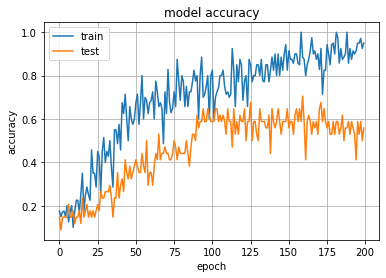

In [16]:
# Lets plot the results
print(history.history.keys())
# history accuracy
plt.plot(history.history["categorical_accuracy"])
plt.plot(history.history["val_categorical_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

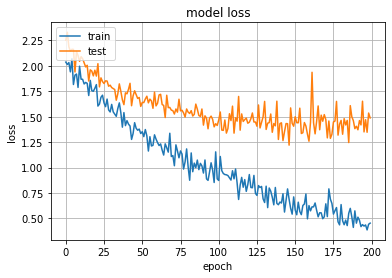

In [17]:
# history accuracy
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

In [18]:
# Lets predict
path = valDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]

for file in imagesPredict:
    img = load_img(path + file, target_size=( 299, 299))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = model.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

file airport_26_1_msrgb.jpg is: airport
file airport_45_3_msrgb.jpg is: airport
file airport_55_0_msrgb.jpg is: airport
file airport_6_0_msrgb.jpg is: amusement_park


In [19]:
loadedModel = load_model("InceptionModel.h5")

path = valDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]
# print(imagesPredict)


for file in imagesPredict:
    img = load_img(path + file, target_size=( 299, 299))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = loadedModel.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

file airport_26_1_msrgb.jpg is: airport
file airport_45_3_msrgb.jpg is: airport
file airport_55_0_msrgb.jpg is: airport
file airport_6_0_msrgb.jpg is: amusement_park
